In [1]:
import numpy as np

from PIL  import Image

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.cluster import KMeans

from IPython.display import display

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import ndimage as ndi
from skimage.morphology import medial_axis

from scipy import ndimage as ndi 
from skimage.morphology import medial_axis
from skimage.morphology import skeletonize

from scipy.spatial import Delaunay

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [3]:
data = np.load("hiragana.npz")['arr_0'] 

In [28]:
letter = data[0,:]

In [5]:
def biColor(X):
    if X>0:
        return 1
    else:
        return 0

In [6]:
flattenFl = letter.flatten()
toWhite = np.vectorize(biColor)
newFlat = toWhite(flattenFl)
WhiteFL = newFlat.reshape(160,127,128).astype(np.uint8)

In [7]:
def moment(array,m1,m2):
    moment = 0
    for y,ver in enumerate(array):
        for x,hor in enumerate(ver):
            moment += pow(x,m1)*pow(y,m2)*hor
    return moment

In [8]:
def center(array):
    x = moment(array,1,0)/moment(array,0,0)
    y = moment(array,0,1)/moment(array,0,0)
    return (x,y)

In [9]:
def translate(array,x,y):
    buffer = np.roll(array,-x,axis=1)
    buffer = np.roll(buffer,-y,axis=0)
    return buffer

In [10]:
def centeredarray(array):
    buffer = []
    for pic in tqdm(array):
        shape = pic.shape
        centroid = center(pic)
        delta_x = -shape[1]/2 + centroid[0]
        delta_y = -shape[0]/2 + centroid[1]

        buffer += [translate(pic,int(delta_x),int(delta_y))]
    return buffer

In [11]:
test = np.array(centeredarray(letter))

In [14]:
def predictPCA(n_components, letter, n_clusters=10, n_init=5):
    letter = letter.reshape(160,16256)
    pca = PCA(n_components=n_components).fit_transform(letter)
    pcak = KMeans(init='k-means++', n_clusters=(n_clusters), n_init=n_init)
    pcak.fit(pca)
    pred = pcak.predict(pca)
    return pred

In [15]:
pred = predictPCA(40, test)

In [16]:
def displayCluster(predicted, centered_array, array, n_cluster):
    inic = [i for i,v in enumerate(predicted) if v ==n_cluster]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)
    ax = axes.ravel()
    
    imgss = [array[i] for i in inic]
    new_img = np.average(imgss, axis = 0)
    
    imgssC = [centered_array[i] for i in inic]
    new_imgC = np.average(imgssC, axis = 0)
    
    ax[0].imshow(new_img)
    ax[1].imshow(new_imgC)
    fig.tight_layout()
    plt.show()

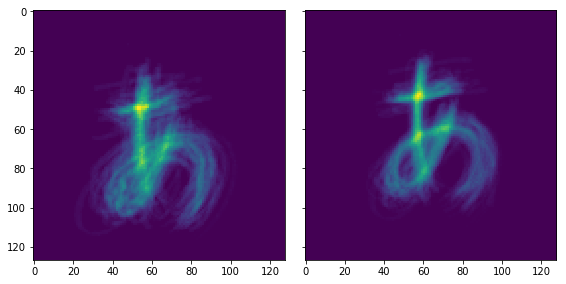

In [28]:
displayCluster(pred, test, letter, 5)

In [40]:
skel, distance = medial_axis(letter[0], return_distance=True)

In [41]:
dist_on_skel = distance * skel


/home/hexagramg/exp/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


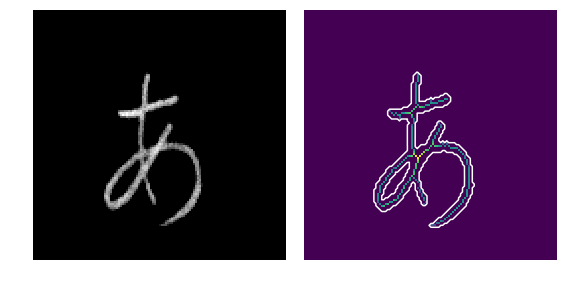

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True,
                               subplot_kw={'adjustable': 'box-forced'})
ax1.imshow(letter[0], cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, interpolation='nearest')
ax2.contour(letter[0], [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()

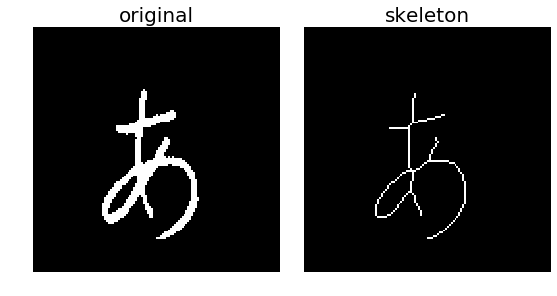

In [23]:
skeleton = skeletonize(WhiteFL[0])

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(WhiteFL[0], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

In [17]:
def toPoints(array):
    flag = True
    leny,lenx = array.shape
    for y, xarr in enumerate(array):
        for x, intens in enumerate(xarr):
            if intens > 10:
                if flag:
                    buffer = np.array([[x,y]])
                    flag = False
                else:
                    point = np.array([[x,leny - y]])
                    buffer = np.append(point,buffer,axis=0)
    return buffer

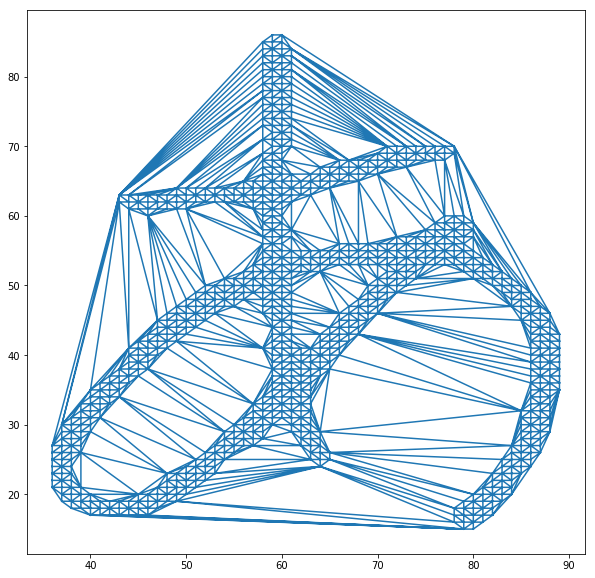

In [29]:
points = toPoints(letter[7])
tri = Delaunay(points, incremental = True )
plt.triplot(points[:,0], points[:,1], tri.simplices)
#plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [18]:
def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [38]:
points = toPoints(letter[7])
alpha = alpha_shape(points,1.5)

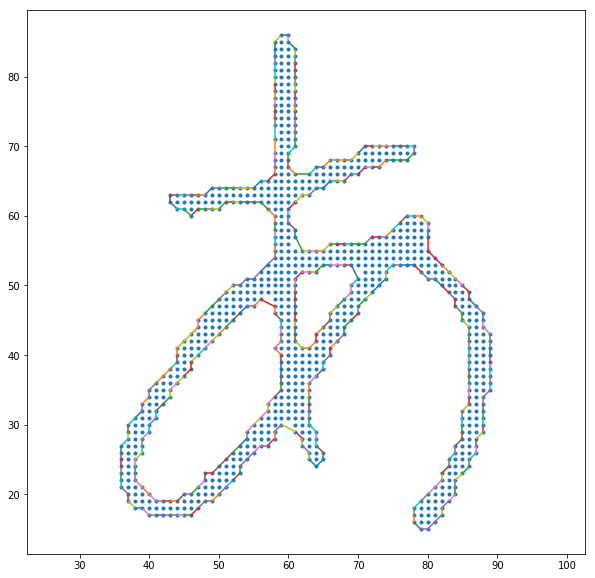

In [39]:
plt.figure()
plt.axis('equal')
plt.plot(points[:, 0], points[:, 1], '.')
for i, j in alpha:
    plt.plot(points[[i, j], 0], points[[i, j], 1])
plt.show()